In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn import model_selection

In [ ]:
data = pd.read_csv('processed.cleveland.data', header = None)

In [ ]:
data.head()

In [ ]:
## The data has been taken from the UCI machine learning repo and the column names need to be assigned
## https://archive.ics.uci.edu/dataset/45/heart+disease
## So, we pick the columns names from the UCI heart disease data repo (link in the above comment)

data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

In [ ]:
## Analyze the data and check for missing values
## 2 ways to deal with missing data: 
## Method1: Remove the col or row with missing data - we use this for now
## Method 2: Impute the missing data by making an educated guess about it

## First we check the ddatatypelink above, columns ca and thal are categorical, so we check the unique values
data.dtypes

In [ ]:
data['ca'].unique()

In [ ]:
data['thal'].unique()

In [ ]:
## Both ca and thal have ? => missing data
## Count the rows with. missing values:
len(data.loc[ (data['ca'] =='?') | (data['thal'] =='?') ])

# Dealing with missing data

In [ ]:
data.loc[ (data['ca'] =='?') | (data['thal'] =='?') ]

In [ ]:
data_no_missing = data.loc[ (data['ca'] !='?') & (data['thal'] !='?') ]
len(data_no_missing)

In [ ]:
## Check unique values in ca and thal
print(data_no_missing['ca'].unique())
print(data_no_missing['thal'].unique())

# Split data into training and test sets

In [ ]:
## The column num tells us whether a person has heart disease or not, so rename it to hd
data_no_missing = data_no_missing.rename(columns = {"num":"hd"})

In [ ]:
## Use hd as the dependent, other columns as predictors
X = data_no_missing.drop("hd", axis = 1).copy()
X

In [ ]:
y = data_no_missing['hd'].copy()
y

# Inspect and Format data to make it fit for decision trees

While sklearn Decision trees natively support continuous or numerical data like cholestrol or thal, they do not support the categorical data like cp or chest pain that contains 4 types of chest pain:
Attribute documentation:
      age: age in years
      sex: sex (1 = male; 0 = female)
      cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
     trestbps: resting blood 
     chol: serum cholestoral in mg/dl
     fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
     estecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
     thalach: maximum heart rate achieved
     exang: exercise induced angina (1 = yes; 0 = no)
     oldpeak = ST depression induced by exercise relative to rest
     slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
     ca: number of major vessels (0-3) colored by flourosopy
     thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [ ]:
## Based on the info on the different attributes given above, we notice that sex, cp, fbs, estecg, exang, slope, ca are all categorical
## The ones with more than 2 categories need to be encoded
## There are two ways to perform One-hot encoding - Use pd.get_dummies (more beginner friendly) or the ColumnTransformer from sklearn (more commonly used in production systems)
X['cp'].unique()

In [ ]:
#pd.get_dummies(X, columns = ['cp'])

In [ ]:
X_encoded = pd.get_dummies(X, columns = ['cp','restecg','slope','thal'])

In [ ]:
## In this tutorial, we create a simple tree with 2 possible outcomes for heart disease - Yes, No
## Convert 4 types of heart disease output to 2
y_not_0_index = y!=0 # get index for all non zero y values
y[y_not_0_index] = 1 # set the value of y for these indices to 1
y.unique() # we are left with 2 unique values only - 0 & 1

# Split data into train and test sets: Build a prelim classification tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,random_state=42)

## Build a preliminary decision classification tree
clf_dt = tree.DecisionTreeClassifier(random_state = 42, max_depth = None)
clf_dt = clf_dt.fit(X_train, y_train)

In [ ]:
X_encoded.columns.tolist()

In [ ]:
plt.figure(figsize = (15,17))
tree.plot_tree(clf_dt, filled = True, rounded = True, class_names = ["No_HD","Yes_HD"], feature_names = X_encoded.columns.tolist())

In [ ]:
#pip show scikit-learn - 1.3.0
#pip show numpy - 1.24.3

In [61]:
## Predict y for the test set and create confusion matrix
y_pred = clf_dt.predict(X_test)
confusion_mat = confusion_matrix(y_test,y_pred)

In [70]:
clf_dt.classes_

array([0, 1])

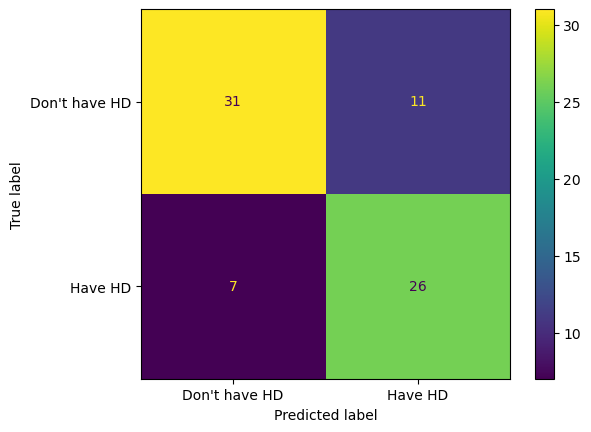

In [71]:
## Display confusion matrix using the Confusion Matrix Display class
cm_display = metrics.ConfusionMatrixDisplay(confusion_mat,display_labels=["Don't have HD","Have HD"])
cm_display.plot()

# Cost Complexity Pruning: Visualize alpha
Pruning a decision tree is all about finding the right value for the pruning parameter alpha. 
One way to do it is to plot the accuracy of tree as a function of alpha. This is done both for training and test sets.

In [82]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) #determine values for alpha
ccp_alphas = path.ccp_alphas # extract alphas
ccp_alphas = ccp_alphas[:-1] #exclude the max value for alpha as it would result in only the root remaining
ccp_alphas

## Create a list of decision trees fit based on different values of alpha
clf_dts = []
for ccp_alpha in ccp_alphas:
    clf_tree = tree.DecisionTreeClassifier(random_state = 42, ccp_alpha = ccp_alpha)
    clf_tree = clf_tree.fit(X_train,y_train)
    clf_dts.append(clf_tree)

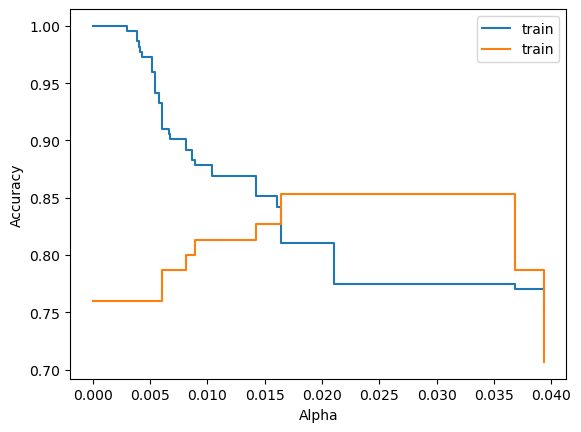

In [94]:
## Store the accuracy scores for different DTs store din clf_dts list
train_scores = [clf_dt.score(X_train,y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,y_test) for clf_dt in clf_dts]

## Generate a plot to see how accuracy changes with change in alpha
fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.plot(ccp_alphas, train_scores, label = "train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, label = "train", drawstyle = "steps-post")
ax.legend()
plt.show()

As we increase alpha, the size of the tree gets smaller, our testing accuracy improves as it controls the overfitting and hence reduces variance.

Just by looking at the plot, we can see that 0.016 is the best value.

# Cost Complexity Pruning: Use k fold Cross Validation to find best alpha
The plot that we have above suggests 0.016 as the best value for alpha but different test train splits may suggest different values of alpha. So, we evaluate alpha values using cross validation.


<Axes: xlabel='tree'>

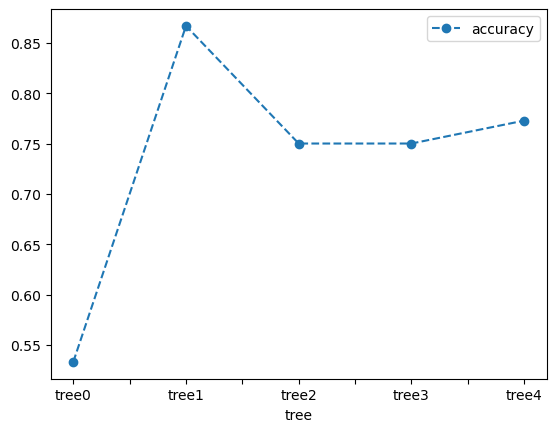

In [121]:
## Let's check how the value of alpha 0.016 results in accuracies using different test train splits
clf_dt_alpha = tree.DecisionTreeClassifier(random_state = 42, ccp_alpha = 0.016)
scores_alpha = model_selection.cross_val_score(clf_dt_alpha, X_train, y_train, cv=5)

## Create a dataframe to store the tree number vs accuracy
tree_list = ['tree' + str(i) for i in list(range(0,5))]
alpha_df = pd.DataFrame({'tree': tree_list, 'accuracy': scores_alpha})

alpha_df.plot(x = 'tree', y='accuracy', marker = 'o', linestyle = '--')

The above plot shows that the alpha value 0.016 ives bad accuracy for the first split (tree0). This shows that alpha is sensitive to dataset and we should use different test train splits to shortlist the value for alpha.

NOTE: Grid search can also be used to find the best value for alpha

<Axes: xlabel='CCP_Alpha'>

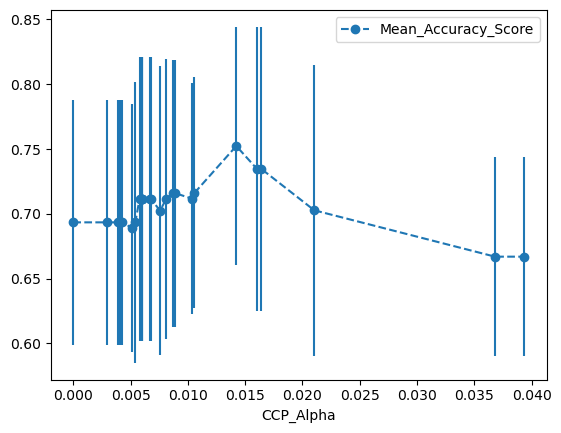

In [129]:
## Now, we run the loop on all alpha values and perform cross validation in this loop for each alpha value\
## This means that for each value of alpha, we create trees on multiple train-test splits, then store the mean accuracy and std deviation
alpha_loop_values = []
for a in ccp_alphas:
    clf_dt_a = tree.DecisionTreeClassifier(random_state = 42, ccp_alpha = a)
    scores_a = model_selection.cross_val_score(clf_dt_a, X_train, y_train, cv=5)
    alpha_loop_values.append([a,np.mean(scores_a),np.std(scores_a)])
    
alpha_score_df = pd.DataFrame(alpha_loop_values, columns = ['CCP_Alpha','Mean_Accuracy_Score','STD_Accuracy_Score'])

alpha_score_df.plot(x = 'CCP_Alpha', y='Mean_Accuracy_Score', yerr = 'STD_Accuracy_Score', marker = 'o', linestyle = '--')




Notice that instead of setting alpha to 0.016, we need to set it to something close to 0.014. So, we dive deep to see the exact value that we need to use.

In [137]:
## Filter the df alpha_score_df for values between 0.014 and 0.015
alpha_score_df = alpha_score_df[ (alpha_score_df['CCP_Alpha'] >= 0.014) & (alpha_score_df['CCP_Alpha'] <= 0.015)].reset_index()
alpha_score_df

,index,CCP_Alpha,Mean_Accuracy_Score,STD_Accuracy_Score
0,20,0.014225,0.752323,0.091956


In [139]:
## Storing the finalized alpha value in a variable
final_alpha = alpha_score_df.loc[0,'CCP_Alpha']
type(final_alpha)

numpy.float64

<Figure size 2000x2500 with 0 Axes>

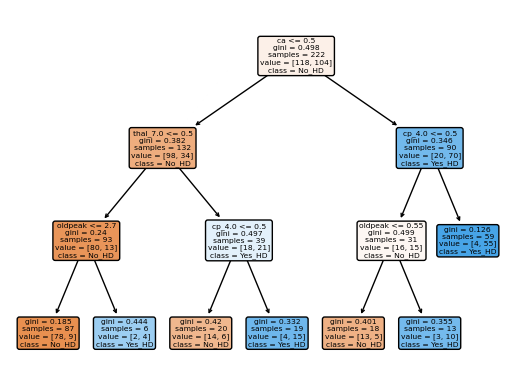

<Figure size 2000x2500 with 0 Axes>

In [150]:
## Create the final Decision Tree
clf_dt_pruned = tree.DecisionTreeClassifier(random_state = 42, ccp_alpha = final_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)

## plot the classification tree using the plot_tree function from sklearn.tree 
tree.plot_tree(clf_dt_pruned,filled = True, rounded = True, class_names = ["No_HD","Yes_HD"], feature_names = X_encoded.columns.tolist())
plt.figure(figsize = (20,25) )

# Interpretation of the plotted classification tree: 
1. Orange color refers to No_HD having more count
2. Blue color refers to Yes_HD class having higher count (majority)
3. The darker the color, the lower the gini impurity for that node (majority)
4. This tree is smaller as it is pruned and it does not overfit the training data
5. The class in each node tells us which class has the majority
6. The leaves don't have the column or feature names as there is no further conditional split

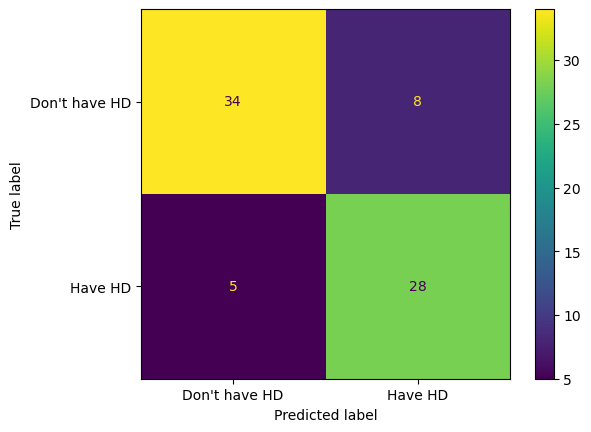

In [147]:
cm_pruned = metrics.confusion_matrix(y_test,y_pred)
## Display confusion matrix using the Confusion Matrix Display class
cm_display = metrics.ConfusionMatrixDisplay(cm_pruned,display_labels=["Don't have HD","Have HD"])
cm_display.plot()

In [152]:
## How to select features in a decision tree?
# Accessing attributes
print("Feature importances:", clf_dt_pruned.feature_importances_)
print("Number of classes:", clf_dt_pruned.n_classes_)
#print("Number of features:", clf_dt_pruned.n_features_)
print("Tree structure:", clf_dt_pruned.tree_)

Feature importances: [0.         0.         0.         0.         0.         0.
 0.         0.12481627 0.50157821 0.         0.         0.
 0.22233782 0.         0.         0.         0.         0.
 0.         0.         0.         0.15126771]
Number of classes: 2
Tree structure: <sklearn.tree._tree.Tree object at 0x15178d840>


In [156]:
##Get feature importances
feature_importances = clf_dt_pruned.feature_importances_
feature_names = X_encoded.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

        Feature  Importance
8            ca    0.501578
12       cp_4.0    0.222338
21     thal_7.0    0.151268
7       oldpeak    0.124816
20     thal_6.0    0.000000
19     thal_3.0    0.000000
18    slope_3.0    0.000000
17    slope_2.0    0.000000
16    slope_1.0    0.000000
15  restecg_2.0    0.000000
14  restecg_1.0    0.000000
13  restecg_0.0    0.000000
0           age    0.000000
1           sex    0.000000
10       cp_2.0    0.000000
9        cp_1.0    0.000000
6         exang    0.000000
5       thalach    0.000000
4           fbs    0.000000
3          chol    0.000000
2      trestbps    0.000000
11       cp_3.0    0.000000


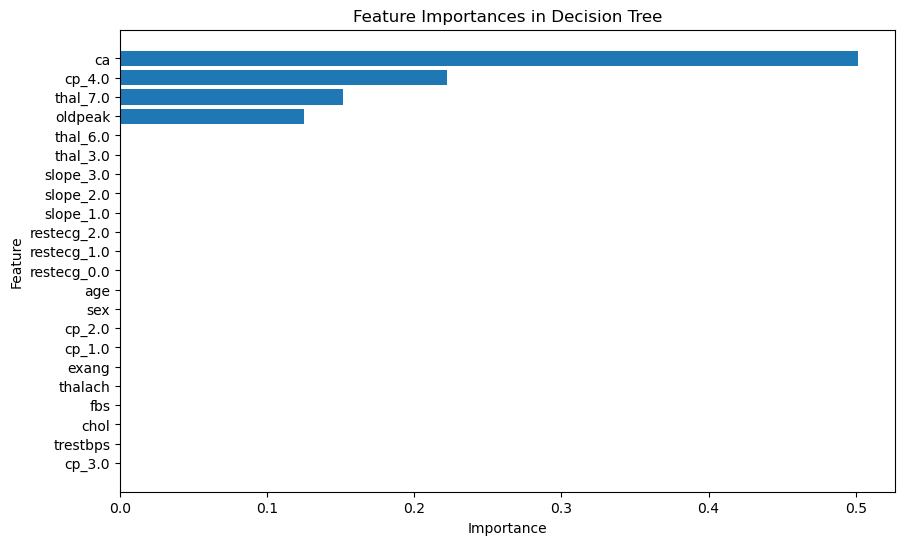

In [157]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree')
plt.gca().invert_yaxis()
plt.show()

In [158]:
# Define a threshold for feature selection
threshold = 0.1

# Select features with importance greater than the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

print("Selected features based on importance threshold:")
print(selected_features)

Selected features based on importance threshold:
8           ca
12      cp_4.0
21    thal_7.0
7      oldpeak
Name: Feature, dtype: object


In [160]:
# Select the important features from the training and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the model with the selected features
clf_selected = tree.DecisionTreeClassifier(random_state=42)

clf_selected.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = clf_selected.score(X_test_selected, y_test)
print(f"Model accuracy with selected features: {accuracy}")

Model accuracy with selected features: 0.84


# Using Grid Search CV class to select best ccp_alpha value for Decision Tree

In [166]:
clf_grid = tree.DecisionTreeClassifier(random_state=42)
# Define the parameter grid for ccp_alpha
#param_grid = {'ccp_alpha': np.linspace(0, 0.02, num=50)}
param_grid = {'ccp_alpha': ccp_alphas}
grid_search = model_selection.GridSearchCV(clf_grid,param_grid = param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': array([0.        , 0.00295295, 0.003861  , 0.00405405, 0.004095  ,
       0.00429358, 0.00514801, 0.00541298, 0.00578761, 0.00600601,
       0.00600601, 0.00600601, 0.00667591, 0.00675676, 0.00757375,
       0.00811505, 0.00868726, 0.00889851, 0.01038181, 0.0105777 ,
       0.01422475, 0.01604051, 0.01642461, 0.02103075, 0.03680006,
       0.03934523])})

In [168]:
param_grid

{'ccp_alpha': array([0.        , 0.00295295, 0.003861  , 0.00405405, 0.004095  ,
        0.00429358, 0.00514801, 0.00541298, 0.00578761, 0.00600601,
        0.00600601, 0.00600601, 0.00667591, 0.00675676, 0.00757375,
        0.00811505, 0.00868726, 0.00889851, 0.01038181, 0.0105777 ,
        0.01422475, 0.01604051, 0.01642461, 0.02103075, 0.03680006,
        0.03934523])}

In [167]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best ccp_alpha: {best_params['ccp_alpha']}")
print(f"Best cross-validated score: {best_score}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)

print(f"Test set score with best ccp_alpha: {test_score}")

Best ccp_alpha: 0.014224751066856332
Best cross-validated score: 0.7523232323232323
Test set score with best ccp_alpha: 0.8266666666666667


NOTE that we get the same value of alpha from both the methods - 
1. using cross validation in combination with looping over alphas 
2. using GridSearchCV to search the param grid for alphas